In [2]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.stats import multivariate_normal, norm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys

from ast import literal_eval

import warnings

## Sample portfolios for illustrative risk calculation

In [4]:
years = 50

n_portfolios = 4
portfolio_assets = np.zeros((n_portfolios, years))
portfolio_liabilities = np.zeros((n_portfolios, years))

def load_portfolios_from_csv(file_path, years=50, n_portfolios=4):
    df = pd.read_csv(file_path)
    
    portfolio_assets = np.zeros((n_portfolios, years))
    portfolio_liabilities = np.zeros((n_portfolios, years))
    
    for i in range(n_portfolios):
        asset_col = f"A{i+1}"
        liability_col = f"L{i+1}"
        portfolio_assets[i] = df[asset_col].values[:years]
        portfolio_liabilities[i] = df[liability_col].values[:years]
    
    return portfolio_assets, portfolio_liabilities

portfolio_assets, portfolio_liabilities = load_portfolios_from_csv('sample_portfolio_v3.1.csv', years=years, n_portfolios=n_portfolios)

def compute_portfolio_pv(asset_cf, liability_cf, discount_factors):
    net_cf = asset_cf - liability_cf
    pv = 0.0
    for t in range(len(net_cf)):
        pv += net_cf[t] * discount_factors[t]
    return pv

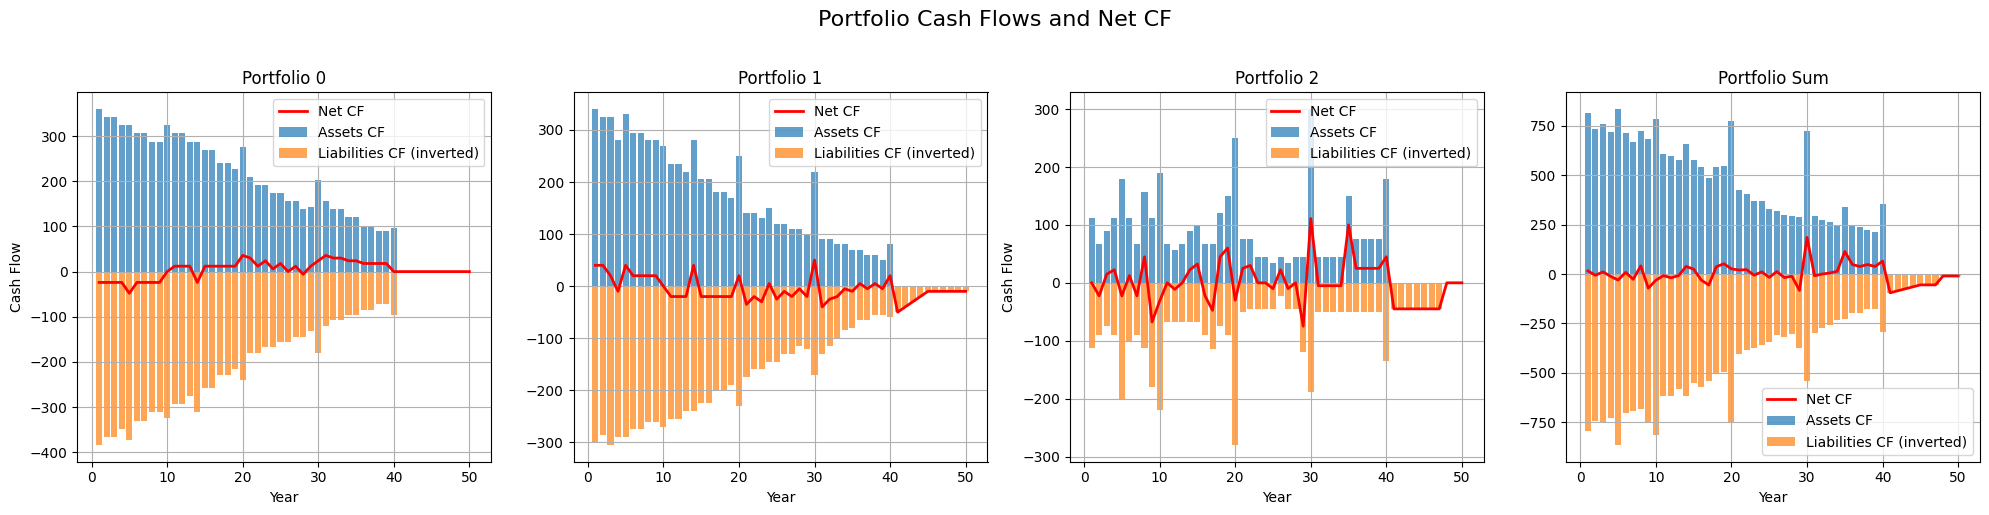

In [5]:
time = np.arange(1, years + 1)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharex=True)
axes = axes.flatten()

for i in range(n_portfolios):
    ax = axes[i]
    asset_cf = portfolio_assets[i]
    liability_cf = portfolio_liabilities[i]
    net_cf = asset_cf - liability_cf

    ax.bar(time, asset_cf, label='Assets CF', alpha=0.7)
    ax.bar(time, -liability_cf, label='Liabilities CF (inverted)', alpha=0.7)
    ax.plot(time, net_cf, color='red', label='Net CF', linewidth=2)

    title = "Portfolio Sum" if i == 3 else f"Portfolio {i}"
    ax.set_title(title)
    ax.set_xlabel('Year')
    if i % 2 == 0:
        ax.set_ylabel('Cash Flow')
    ax.legend()
    ax.grid(True)

fig.suptitle('Portfolio Cash Flows and Net CF', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Risk calculation for DNS (ICS risk calculation)

### 1-day risk back test

In [112]:
def calculate_portfolio_risk_from_yield_df(yield_df, portfolio_assets, portfolio_liabilities,
                                             n_sims=20000, seed=513):
    rng = np.random.default_rng(seed=seed)
    z_995 = norm.ppf(0.995)
    risk_charges_dict = {}

    grouped = yield_df.groupby("Test_Date")
    for test_date, group in grouped:
        group = group.sort_values("Maturity")
        
        base_yields = group["Base Yield"].values
        mr_yields   = group["Mean Reversion"].values
        lu_yields   = group["Level Up"].values
        ld_yields   = group["Level Down"].values
        tu_yields   = group["Twist Up-to-Down"].values
        td_yields   = group["Twist Down-to-Up"].values
            
        base_df = 1.0 / ((1.0 + base_yields) ** maturities_float)
        mr_df   = 1.0 / ((1.0 + mr_yields)   ** maturities_float)
        lu_df   = 1.0 / ((1.0 + lu_yields)   ** maturities_float)
        ld_df   = 1.0 / ((1.0 + ld_yields)   ** maturities_float)
        tu_df   = 1.0 / ((1.0 + tu_yields)   ** maturities_float)
        td_df   = 1.0 / ((1.0 + td_yields)   ** maturities_float)
        
        n_portfolios = len(portfolio_assets)
        risk_charges = np.zeros(n_portfolios)
        for i in range(n_portfolios):
            net_cf = portfolio_assets[i] - portfolio_liabilities[i]
            base_pv = np.sum(net_cf * base_df)
            mr_pv   = np.sum(net_cf * mr_df)
            lu_pv   = np.sum(net_cf * lu_df)
            ld_pv   = np.sum(net_cf * ld_df)
            tu_pv   = np.sum(net_cf * tu_df)
            td_pv   = np.sum(net_cf * td_df)
            
            
            MR_diff = mr_pv - base_pv
            LU_diff = lu_pv - base_pv
            LD_diff = ld_pv - base_pv
            TU_diff = tu_pv - base_pv
            TD_diff = td_pv - base_pv
            
            
            LT_sims = np.zeros(n_sims)
            for sim in range(n_sims):
                X = rng.normal(0, 1)
                Y = rng.normal(0, 1)
                LT = (1.0 / z_995) * (
                    LU_diff * max(X, 0) -
                    LD_diff * min(X, 0) +
                    TU_diff * max(Y, 0) -
                    TD_diff * min(Y, 0)
                )
                LT_sims[sim] = LT
            sorted_LT = np.sort(LT_sims)
            idx_995 = int(0.995 * n_sims)
            VaR_995 = sorted_LT[idx_995]
            risk_charges[i] = max(0.0, MR_diff + VaR_995)
        
        risk_charges_dict[test_date] = risk_charges.tolist()
        #print(f"Test Date: {test_date}, Risk Charges: {risk_charges}")
    
    return risk_charges_dict


yield_df = pd.read_csv("DNS40_ICS_1-day_risk_yields.csv")
maturities_float = np.arange(1, 51)

risk_charges = calculate_portfolio_risk_from_yield_df(yield_df,
                                                       portfolio_assets, portfolio_liabilities,
                                                       n_sims=20000, seed=513)

risk_charges_df = pd.DataFrame([
    {'Test_Date': test_date, 'Risk_Charges': rc} for test_date, rc in risk_charges.items()
])
risk_charges_df.to_csv("DNS40_1-day_risk_backtest_v3.1.csv", index=False)


### 1-weekly risk back test

In [113]:
def calculate_portfolio_risk_from_yield_df(yield_df, portfolio_assets, portfolio_liabilities,
                                             n_sims=20000, seed=513):
    rng = np.random.default_rng(seed=seed)
    z_995 = norm.ppf(0.995)
    risk_charges_dict = {}

    grouped = yield_df.groupby("Test_Date")
    for test_date, group in grouped:
        group = group.sort_values("Maturity")
        
        base_yields = group["Base Yield"].values
        mr_yields   = group["Mean Reversion"].values
        lu_yields   = group["Level Up"].values
        ld_yields   = group["Level Down"].values
        tu_yields   = group["Twist Up-to-Down"].values
        td_yields   = group["Twist Down-to-Up"].values
            
        base_df = 1.0 / ((1.0 + base_yields) ** maturities_float)
        mr_df   = 1.0 / ((1.0 + mr_yields)   ** maturities_float)
        lu_df   = 1.0 / ((1.0 + lu_yields)   ** maturities_float)
        ld_df   = 1.0 / ((1.0 + ld_yields)   ** maturities_float)
        tu_df   = 1.0 / ((1.0 + tu_yields)   ** maturities_float)
        td_df   = 1.0 / ((1.0 + td_yields)   ** maturities_float)
        
        n_portfolios = len(portfolio_assets)
        risk_charges = np.zeros(n_portfolios)
        for i in range(n_portfolios):
            net_cf = portfolio_assets[i] - portfolio_liabilities[i]
            base_pv = np.sum(net_cf * base_df)
            mr_pv   = np.sum(net_cf * mr_df)
            lu_pv   = np.sum(net_cf * lu_df)
            ld_pv   = np.sum(net_cf * ld_df)
            tu_pv   = np.sum(net_cf * tu_df)
            td_pv   = np.sum(net_cf * td_df)
            
            
            MR_diff = mr_pv - base_pv
            LU_diff = lu_pv - base_pv
            LD_diff = ld_pv - base_pv
            TU_diff = tu_pv - base_pv
            TD_diff = td_pv - base_pv
            
            
            LT_sims = np.zeros(n_sims)
            for sim in range(n_sims):
                X = rng.normal(0, 1)
                Y = rng.normal(0, 1)
                LT = (1.0 / z_995) * (
                    LU_diff * max(X, 0) -
                    LD_diff * min(X, 0) +
                    TU_diff * max(Y, 0) -
                    TD_diff * min(Y, 0)
                )
                LT_sims[sim] = LT
            sorted_LT = np.sort(LT_sims)
            idx_995 = int(0.995 * n_sims)
            VaR_995 = sorted_LT[idx_995]
            risk_charges[i] = max(0.0, MR_diff + VaR_995)
        
        risk_charges_dict[test_date] = risk_charges.tolist()
        #print(f"Test Date: {test_date}, Risk Charges: {risk_charges}")
    
    return risk_charges_dict


yield_df = pd.read_csv("DNS40_ICS_1-week_risk_yields.csv")
maturities_float = np.arange(1, 51)

risk_charges = calculate_portfolio_risk_from_yield_df(yield_df,
                                                       portfolio_assets, portfolio_liabilities,
                                                       n_sims=20000, seed=513)

risk_charges_df = pd.DataFrame([
    {'Test_Date': test_date, 'Risk_Charges': rc} for test_date, rc in risk_charges.items()
])
risk_charges_df.to_csv("DNS40_1-week_risk_backtest_v3.1.csv", index=False)


### 1-month risk back test

In [114]:
def calculate_portfolio_risk_from_yield_df(yield_df, portfolio_assets, portfolio_liabilities,
                                             n_sims=20000, seed=513):
    rng = np.random.default_rng(seed=seed)
    z_995 = norm.ppf(0.995)
    risk_charges_dict = {}

    grouped = yield_df.groupby("Test_Date")
    for test_date, group in grouped:
        group = group.sort_values("Maturity")
        
        base_yields = group["Base Yield"].values
        mr_yields   = group["Mean Reversion"].values
        lu_yields   = group["Level Up"].values
        ld_yields   = group["Level Down"].values
        tu_yields   = group["Twist Up-to-Down"].values
        td_yields   = group["Twist Down-to-Up"].values
            
        base_df = 1.0 / ((1.0 + base_yields) ** maturities_float)
        mr_df   = 1.0 / ((1.0 + mr_yields)   ** maturities_float)
        lu_df   = 1.0 / ((1.0 + lu_yields)   ** maturities_float)
        ld_df   = 1.0 / ((1.0 + ld_yields)   ** maturities_float)
        tu_df   = 1.0 / ((1.0 + tu_yields)   ** maturities_float)
        td_df   = 1.0 / ((1.0 + td_yields)   ** maturities_float)
        
        n_portfolios = len(portfolio_assets)
        risk_charges = np.zeros(n_portfolios)
        for i in range(n_portfolios):
            net_cf = portfolio_assets[i] - portfolio_liabilities[i]
            base_pv = np.sum(net_cf * base_df)
            mr_pv   = np.sum(net_cf * mr_df)
            lu_pv   = np.sum(net_cf * lu_df)
            ld_pv   = np.sum(net_cf * ld_df)
            tu_pv   = np.sum(net_cf * tu_df)
            td_pv   = np.sum(net_cf * td_df)
            
            
            MR_diff = mr_pv - base_pv
            LU_diff = lu_pv - base_pv
            LD_diff = ld_pv - base_pv
            TU_diff = tu_pv - base_pv
            TD_diff = td_pv - base_pv
            
            
            LT_sims = np.zeros(n_sims)
            for sim in range(n_sims):
                X = rng.normal(0, 1)
                Y = rng.normal(0, 1)
                LT = (1.0 / z_995) * (
                    LU_diff * max(X, 0) -
                    LD_diff * min(X, 0) +
                    TU_diff * max(Y, 0) -
                    TD_diff * min(Y, 0)
                )
                LT_sims[sim] = LT
            sorted_LT = np.sort(LT_sims)
            idx_995 = int(0.995 * n_sims)
            VaR_995 = sorted_LT[idx_995]
            risk_charges[i] = max(0.0, MR_diff + VaR_995)
        
        risk_charges_dict[test_date] = risk_charges.tolist()
        #print(f"Test Date: {test_date}, Risk Charges: {risk_charges}")
    
    return risk_charges_dict


yield_df = pd.read_csv("DNS40_ICS_1-month_risk_yields.csv")
maturities_float = np.arange(1, 51)

risk_charges = calculate_portfolio_risk_from_yield_df(yield_df,
                                                       portfolio_assets, portfolio_liabilities,
                                                       n_sims=20000, seed=513)

risk_charges_df = pd.DataFrame([
    {'Test_Date': test_date, 'Risk_Charges': rc} for test_date, rc in risk_charges.items()
])
risk_charges_df.to_csv("DNS40_1-month_risk_backtest_v3.1.csv", index=False)


### 1-year risk back test

In [6]:
def calculate_portfolio_risk_from_yield_df(yield_df, portfolio_assets, portfolio_liabilities,
                                             n_sims=20000, seed=513):
    rng = np.random.default_rng(seed=seed)
    z_995 = norm.ppf(0.995)
    risk_charges_dict = {}

    grouped = yield_df.groupby("Test_Date")
    for test_date, group in grouped:
        group = group.sort_values("Maturity")
        
        base_yields = group["Base Yield"].values
        mr_yields   = group["Mean Reversion"].values
        lu_yields   = group["Level Up"].values
        ld_yields   = group["Level Down"].values
        tu_yields   = group["Twist Up-to-Down"].values
        td_yields   = group["Twist Down-to-Up"].values
            
        base_df = 1.0 / ((1.0 + base_yields) ** maturities_float)
        mr_df   = 1.0 / ((1.0 + mr_yields)   ** maturities_float)
        lu_df   = 1.0 / ((1.0 + lu_yields)   ** maturities_float)
        ld_df   = 1.0 / ((1.0 + ld_yields)   ** maturities_float)
        tu_df   = 1.0 / ((1.0 + tu_yields)   ** maturities_float)
        td_df   = 1.0 / ((1.0 + td_yields)   ** maturities_float)
        
        n_portfolios = len(portfolio_assets)
        risk_charges = np.zeros(n_portfolios)
        for i in range(n_portfolios):
            net_cf = portfolio_assets[i] - portfolio_liabilities[i]
            base_pv = np.sum(net_cf * base_df)
            mr_pv   = np.sum(net_cf * mr_df)
            lu_pv   = np.sum(net_cf * lu_df)
            ld_pv   = np.sum(net_cf * ld_df)
            tu_pv   = np.sum(net_cf * tu_df)
            td_pv   = np.sum(net_cf * td_df)
            
            
            MR_diff = mr_pv - base_pv
            LU_diff = lu_pv - base_pv
            LD_diff = ld_pv - base_pv
            TU_diff = tu_pv - base_pv
            TD_diff = td_pv - base_pv
            
            
            LT_sims = np.zeros(n_sims)
            for sim in range(n_sims):
                X = rng.normal(0, 1)
                Y = rng.normal(0, 1)
                LT = (1.0 / z_995) * (
                    LU_diff * max(X, 0) -
                    LD_diff * min(X, 0) +
                    TU_diff * max(Y, 0) -
                    TD_diff * min(Y, 0)
                )
                LT_sims[sim] = LT
            sorted_LT = np.sort(LT_sims)
            idx_995 = int(0.995 * n_sims)
            VaR_995 = sorted_LT[idx_995]
            risk_charges[i] = max(0.0, MR_diff + VaR_995)
        
        risk_charges_dict[test_date] = risk_charges.tolist()
        #print(f"Test Date: {test_date}, Risk Charges: {risk_charges}")
    
    return risk_charges_dict


yield_df = pd.read_csv("DNS40_ICS_1-year_risk_yields_v2.1.csv")
maturities_float = np.arange(1, 51)

risk_charges = calculate_portfolio_risk_from_yield_df(yield_df,
                                                       portfolio_assets, portfolio_liabilities,
                                                       n_sims=20000, seed=513)

risk_charges_df = pd.DataFrame([
    {'Test_Date': test_date, 'Risk_Charges': rc} for test_date, rc in risk_charges.items()
])
risk_charges_df.to_csv("DNS40_1-year_risk_backtest_v3.1.csv", index=False)


KeyboardInterrupt: 

### 1-year backtest (DNS30)

In [29]:
def calculate_portfolio_risk_from_yield_df(yield_df, portfolio_assets, portfolio_liabilities,
                                             n_sims=20000, seed=513):
    rng = np.random.default_rng(seed=seed)
    z_995 = norm.ppf(0.995)
    risk_charges_dict = {}

    grouped = yield_df.groupby("Test_Date")
    for test_date, group in grouped:
        group = group.sort_values("Maturity")
        
        base_yields = group["Base Yield"].values
        mr_yields   = group["Mean Reversion"].values
        lu_yields   = group["Level Up"].values
        ld_yields   = group["Level Down"].values
        tu_yields   = group["Twist Up-to-Down"].values
        td_yields   = group["Twist Down-to-Up"].values
            
        base_df = 1.0 / ((1.0 + base_yields) ** maturities_float)
        mr_df   = 1.0 / ((1.0 + mr_yields)   ** maturities_float)
        lu_df   = 1.0 / ((1.0 + lu_yields)   ** maturities_float)
        ld_df   = 1.0 / ((1.0 + ld_yields)   ** maturities_float)
        tu_df   = 1.0 / ((1.0 + tu_yields)   ** maturities_float)
        td_df   = 1.0 / ((1.0 + td_yields)   ** maturities_float)
        
        n_portfolios = len(portfolio_assets)
        risk_charges = np.zeros(n_portfolios)
        for i in range(n_portfolios):
            net_cf = portfolio_assets[i] - portfolio_liabilities[i]
            base_pv = np.sum(net_cf * base_df)
            mr_pv   = np.sum(net_cf * mr_df)
            lu_pv   = np.sum(net_cf * lu_df)
            ld_pv   = np.sum(net_cf * ld_df)
            tu_pv   = np.sum(net_cf * tu_df)
            td_pv   = np.sum(net_cf * td_df)
            
            
            MR_diff = mr_pv - base_pv
            LU_diff = lu_pv - base_pv
            LD_diff = ld_pv - base_pv
            TU_diff = tu_pv - base_pv
            TD_diff = td_pv - base_pv
            
            
            LT_sims = np.zeros(n_sims)
            for sim in range(n_sims):
                X = rng.normal(0, 1)
                Y = rng.normal(0, 1)
                LT = (1.0 / z_995) * (
                    LU_diff * max(X, 0) -
                    LD_diff * min(X, 0) +
                    TU_diff * max(Y, 0) -
                    TD_diff * min(Y, 0)
                )
                LT_sims[sim] = LT
            sorted_LT = np.sort(LT_sims)
            idx_995 = int(0.995 * n_sims)
            VaR_995 = sorted_LT[idx_995]
            risk_charges[i] = max(0.0, MR_diff + VaR_995)
        
        risk_charges_dict[test_date] = risk_charges.tolist()
        #print(f"Test Date: {test_date}, Risk Charges: {risk_charges}")
    
    return risk_charges_dict


yield_df = pd.read_csv("DNS30regu_ICS_1-year_risk_yields_v2.3.csv")
maturities_float = np.arange(1, 51)

risk_charges = calculate_portfolio_risk_from_yield_df(yield_df,
                                                       portfolio_assets, portfolio_liabilities,
                                                       n_sims=20000, seed=513)

risk_charges_df = pd.DataFrame([
    {'Test_Date': test_date, 'Risk_Charges': rc} for test_date, rc in risk_charges.items()
])
risk_charges_df.to_csv("DNS30regu_1-year_risk_backtest_v3.2.csv", index=False)


## Emprical risk

In [117]:
warnings.filterwarnings("ignore", category=UserWarning)
years = 50
# Data Loading and Interpolation
df = pd.read_csv("daily_smith_wilson_20000101_.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df = df[df["Date"] >= "2000-01-01"]
df = df.sort_values("Date").reset_index(drop=True)
df = df.iloc[:, :51]

# use if you want to interpolate the yield curve
# Known maturities and target interpolation maturities (1 to 50 years)
# x_known = np.array([1, 5, 7, 10, 15, 20, 25, 30, 40])
# x_interp = np.arange(1, 51).astype(float)
# def interpolate_yield(row):
    # Interpolate yield curve using Cubic Spline; column names = string of integer maturities.
#    vals = row[[str(t) for t in x_known]].values.astype(float)
#    cs = CubicSpline(x_known, vals, bc_type='natural')
#    return cs(x_interp)

# yield_interp = df.apply(lambda row: pd.Series(interpolate_yield(row), index=[str(int(t)) for t in x_interp]), axis=1)
# yield_interp["Date"] = df["Date"]
# yield_interp = yield_interp.set_index("Date")

yield_interp = df.copy()
yield_interp = yield_interp.set_index("Date")

# Backtesting: Risk & Sliding-window VaR Calculation
horizons = {
    "1-Day":   {"window_size": 1,   "risk_window_size": 504},
    "1-Week":  {"window_size": 5,   "risk_window_size": 504},
    "1-Month": {"window_size": 21,  "risk_window_size": 504},
    "1-Year":  {"window_size": 252, "risk_window_size": 504}
}

quantile_level = 0.95  # VaR percentile


extra_obs = True
risk_measure = "end"  # max or end

results_by_horizon = {}

for horizon_label, params in horizons.items():
    window_size = params["window_size"]
    risk_window_size = params["risk_window_size"]
    
    effective_window = window_size + 1 if extra_obs else window_size
    
    risk_results = []
    all_dates = yield_interp.index.sort_values()
    
    for start in range(0, len(all_dates) - effective_window + 1):
        window_dates = all_dates[start: start + effective_window]
        window_yield = yield_interp.loc[window_dates]
        
        base_date = window_dates[0]
        base_yields = window_yield.iloc[0].values.astype(float)
        
        base_df = np.array([1.0 / ((1.0 + base_yields[t]) ** (t+1)) for t in range(years)])
        
        pv_diff_all = np.zeros((n_portfolios, effective_window))
        base_pv = np.zeros(n_portfolios)
        for i in range(n_portfolios):
            base_pv[i] = compute_portfolio_pv(portfolio_assets[i], portfolio_liabilities[i], base_df)
        
        for j, dt in enumerate(window_dates):
            yields_today = window_yield.loc[dt].values.astype(float)
            discount_factors_today = np.array([1.0 / ((1.0 + yields_today[t]) ** (t+1)) for t in range(years)])
            for i in range(n_portfolios):
                pv_today = compute_portfolio_pv(portfolio_assets[i], portfolio_liabilities[i], discount_factors_today)
                pv_diff_all[i, j] = pv_today - base_pv[i]
        
        risk_for_date = {}
        risk_for_date["Base_Date"] = base_date
        
        for i in range(n_portfolios):
            if risk_measure == "max":
                risk = -np.min(pv_diff_all[i, :])
            elif risk_measure == "end":
                risk = -(pv_diff_all[i, -1])
            else:
                risk = -np.min(pv_diff_all[i, :])
            risk_for_date[f"Portfolio_{i}_risk"] = risk
        
        risk_results.append(risk_for_date)
    
    risk_df = pd.DataFrame(risk_results)
    risk_df = risk_df.sort_values("Base_Date").reset_index(drop=True)
    
    final_risk_results = []
    all_risk_dates = risk_df["Base_Date"].sort_values().reset_index(drop=True)

    for idx in range(risk_window_size - 1, len(all_risk_dates)):
        current_date = all_risk_dates.iloc[idx]
        past_dates = all_risk_dates.iloc[idx - risk_window_size + 1 : idx + 1]
        window_risk = risk_df[risk_df["Base_Date"].isin(past_dates)]

        risk_for_date = {"RiskWindow_Base_Date": current_date}
        for i in range(n_portfolios):
            col = f"Portfolio_{i}_risk"
            var_val = np.quantile(window_risk[col].values, quantile_level)
            risk_for_date[f"Portfolio_{i}_VaR"] = var_val
        final_risk_results.append(risk_for_date)
    
    final_risk_df = pd.DataFrame(final_risk_results)
    final_risk_df = final_risk_df.sort_values("RiskWindow_Base_Date").reset_index(drop=True)
    
    results_by_horizon[horizon_label] = {"risk_df": risk_df, "final_risk_df": final_risk_df}

In [118]:
all_final = []
for horizon_label, dfs in results_by_horizon.items():
    df = dfs["final_risk_df"].copy()
    df["Horizon"] = horizon_label
    all_final.append(df)

empirical_VaR = pd.concat(all_final, ignore_index=True)
empirical_VaR.to_csv(
    "Empirical_VaR_v.3.1.csv",
    index=False,
    date_format="%Y-%m-%d"
)

all_risk = []
for horizon_label, dfs in results_by_horizon.items():
    df = dfs["risk_df"].copy()
    df["Horizon"] = horizon_label
    all_risk.append(df)

empirical_risk = pd.concat(all_risk, ignore_index=True)
empirical_risk.to_csv(
    "Empirical_risk_v3.1.csv",
    index=False,
    date_format="%Y-%m-%d"
)

## Summary

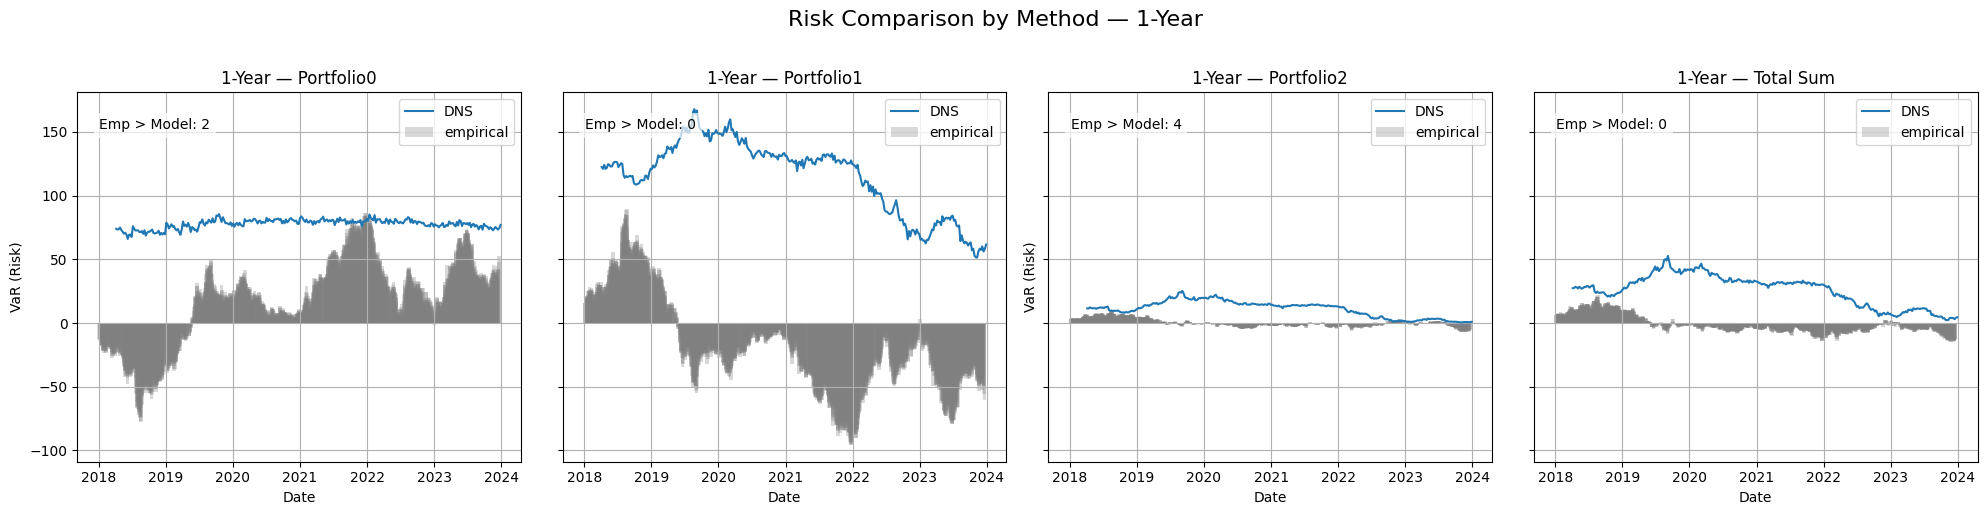

In [14]:
# --- Load Empirical Data ---
start_date = pd.to_datetime("2018-01-01")
end_date   = pd.to_datetime("2023-12-31")

emp_risk_df = pd.read_csv("Empirical_risk_v3.1.csv", encoding="utf-8")
emp_risk_df["Date"] = pd.to_datetime(emp_risk_df["Base_Date"])
emp_risk_df = emp_risk_df.rename(columns={
    "Portfolio_0_risk": "Portfolio0",
    "Portfolio_1_risk": "Portfolio1",
    "Portfolio_2_risk": "Portfolio2",
    "Portfolio_3_risk": "PortfolioSum",
})
emp_risk_df["Label"] = "empirical"

# --- DNS Loader ---
def load_dns(path, horizon_label, model_label):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Test_Date"])
    df["Risk_Charges"] = df["Risk_Charges"].apply(literal_eval)
    risk = pd.DataFrame(df["Risk_Charges"].tolist(),
                        columns=["Portfolio0","Portfolio1","Portfolio2","PortfolioSum"])
    df = pd.concat([df, risk], axis=1).drop(columns=["Test_Date","Risk_Charges"])
    df["Horizon"] = horizon_label
    df["Label"]   = model_label
    return df[["Date","Portfolio0","Portfolio1","Portfolio2","PortfolioSum","Horizon","Label"]]

dns_y    = load_dns("DNS40_1-year_risk_backtest_v3.1.csv",    "1-Year", "DNS")

# --- Combine ---
all_df = pd.concat([emp_risk_df, dns_y], ignore_index=True)
mask = (all_df["Date"] >= start_date) & (all_df["Date"] <= end_date)
all_df = all_df.loc[mask].sort_values("Date")

# --- Plot 2x2 Subplots ---
ports = ["Portfolio0","Portfolio1","Portfolio2","PortfolioSum"]
horizon_order = ["1-Year"]

for horizon in horizon_order:
    df_h = all_df[all_df["Horizon"] == horizon]
    if df_h.empty:
        continue

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)
    axes = axes.flatten()
    for i, port in enumerate(ports):
        ax = axes[i]
        
        pivot = df_h.pivot(index="Date", columns="Label", values=port)
        count_exceed = (pivot["empirical"] > pivot["DNS"]).sum()

        for label, grp in df_h.groupby("Label"):
            if label == "empirical":
                ax.bar(grp["Date"], grp[port],
                       width=20, alpha=0.3, color="gray", label=label)
            else:
                ax.plot(grp["Date"], grp[port], label=label)
        title = port if port != "PortfolioSum" else "Total Sum"
        ax.set_title(f"{horizon} — {title}")
        ax.set_xlabel("Date")
        if i % 2 == 0:
            ax.set_ylabel("VaR (Risk)")
        ax.legend()
        ax.grid(True)

        ax.text(
            0.05, 0.90,
            f"Emp > Model: {count_exceed}",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    fig.suptitle(f"Risk Comparison by Method — {horizon}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


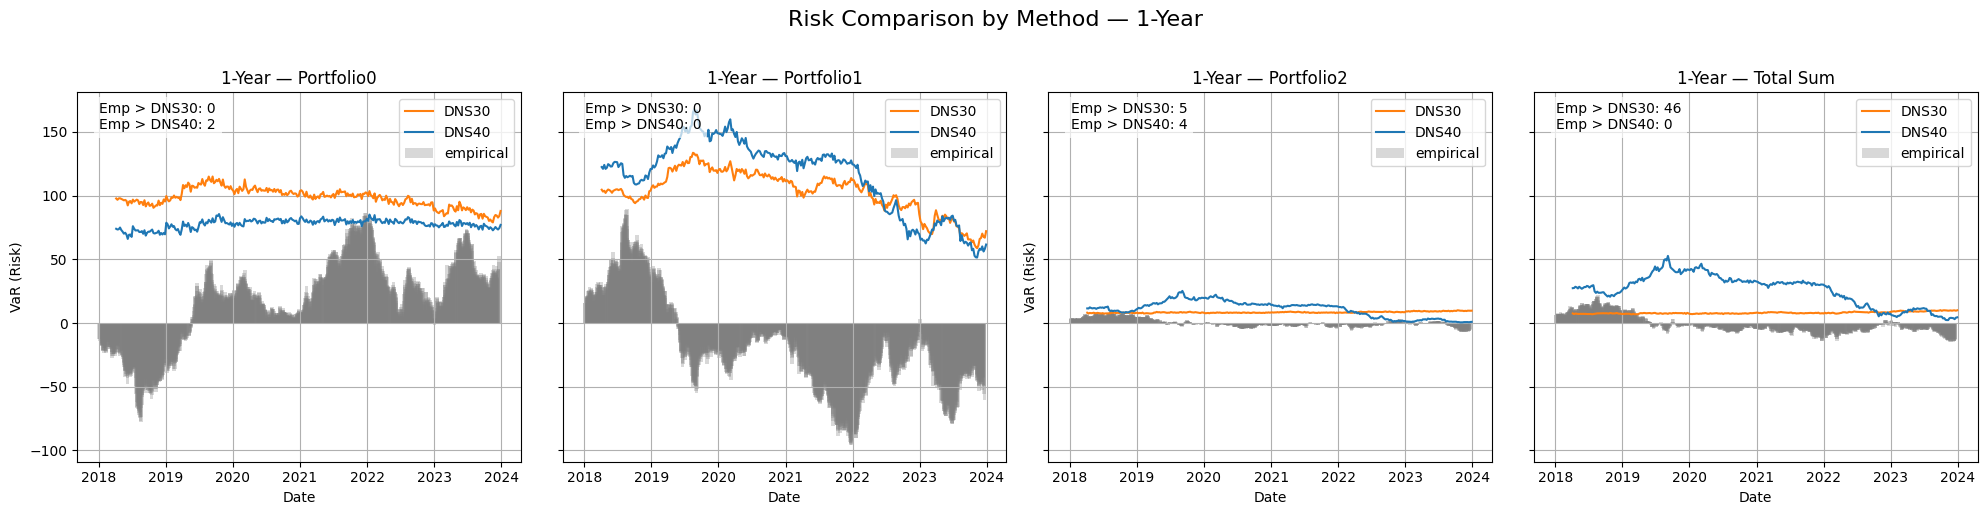

In [ ]:
# --- Load Empirical Data ---
start_date = pd.to_datetime("2018-01-01")
end_date   = pd.to_datetime("2023-12-31")

emp_risk_df = pd.read_csv("Empirical_risk_v3.1.csv", encoding="utf-8")
emp_risk_df["Date"] = pd.to_datetime(emp_risk_df["Base_Date"])
emp_risk_df = emp_risk_df.rename(columns={
    "Portfolio_0_risk": "Portfolio0",
    "Portfolio_1_risk": "Portfolio1",
    "Portfolio_2_risk": "Portfolio2",
    "Portfolio_3_risk": "PortfolioSum",
})
emp_risk_df["Label"] = "empirical"

# --- DNS Loader ---
def load_dns(path, horizon_label, model_label):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Test_Date"])
    df["Risk_Charges"] = df["Risk_Charges"].apply(literal_eval)
    risk = pd.DataFrame(df["Risk_Charges"].tolist(),
                        columns=["Portfolio0","Portfolio1","Portfolio2","PortfolioSum"])
    df = pd.concat([df, risk], axis=1).drop(columns=["Test_Date","Risk_Charges"])
    df["Horizon"] = horizon_label
    df["Label"]   = model_label
    return df[["Date","Portfolio0","Portfolio1","Portfolio2","PortfolioSum","Horizon","Label"]]

dns_y    = load_dns("DNS40_1-year_risk_backtest_v3.1.csv",    "1-Year", "DNS40")
dns_y2    = load_dns("DNS30regu_1-year_risk_backtest_v3.2.csv",    "1-Year", "DNS30")

# --- Combine ---
all_df = pd.concat([emp_risk_df, dns_y2,dns_y], ignore_index=True)
mask = (all_df["Date"] >= start_date) & (all_df["Date"] <= end_date)
all_df = all_df.loc[mask].sort_values("Date")

import matplotlib.pyplot as plt

# --- Plot 2x2 Subplots ---
ports = ["Portfolio0","Portfolio1","Portfolio2","PortfolioSum"]
horizon_order = ["1-Year"]

color_map = {
    "DNS40": "C0",
    "DNS30": "C1",
    "empirical": "gray",
}

for horizon in horizon_order:
    df_h = all_df[all_df["Horizon"] == horizon]
    if df_h.empty:
        continue

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)
    axes = axes.flatten()

    for i, port in enumerate(ports):
        ax = axes[i]

        pivot = df_h.pivot(index="Date", columns="Label", values=port)
        count_exceed40 = (pivot["empirical"] > pivot["DNS40"]).sum()
        count_exceed30 = (pivot["empirical"] > pivot["DNS30"]).sum()

        for label, grp in df_h.groupby("Label"):
            if label == "empirical":
                ax.bar(grp["Date"], grp[port],
                       width=20, alpha=0.3, color=color_map[label], label=label)
            else:
                ax.plot(grp["Date"], grp[port],
                        label=label,
                        color=color_map[label],
                        linewidth=1.5)

        title = port if port != "PortfolioSum" else "Total Sum"
        ax.set_title(f"{horizon} — {title}")
        ax.set_xlabel("Date")
        if i % 2 == 0:
            ax.set_ylabel("VaR (Risk)")
        ax.legend()
        ax.grid(True)

        textstr = (
            f"Emp > DNS30: {count_exceed30}\n"
            f"Emp > DNS40: {count_exceed40}"
        )
        ax.text(
            0.05, 0.90,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    fig.suptitle(f"Risk Comparison by Method — {horizon}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


### Back test for shorter risk horizons

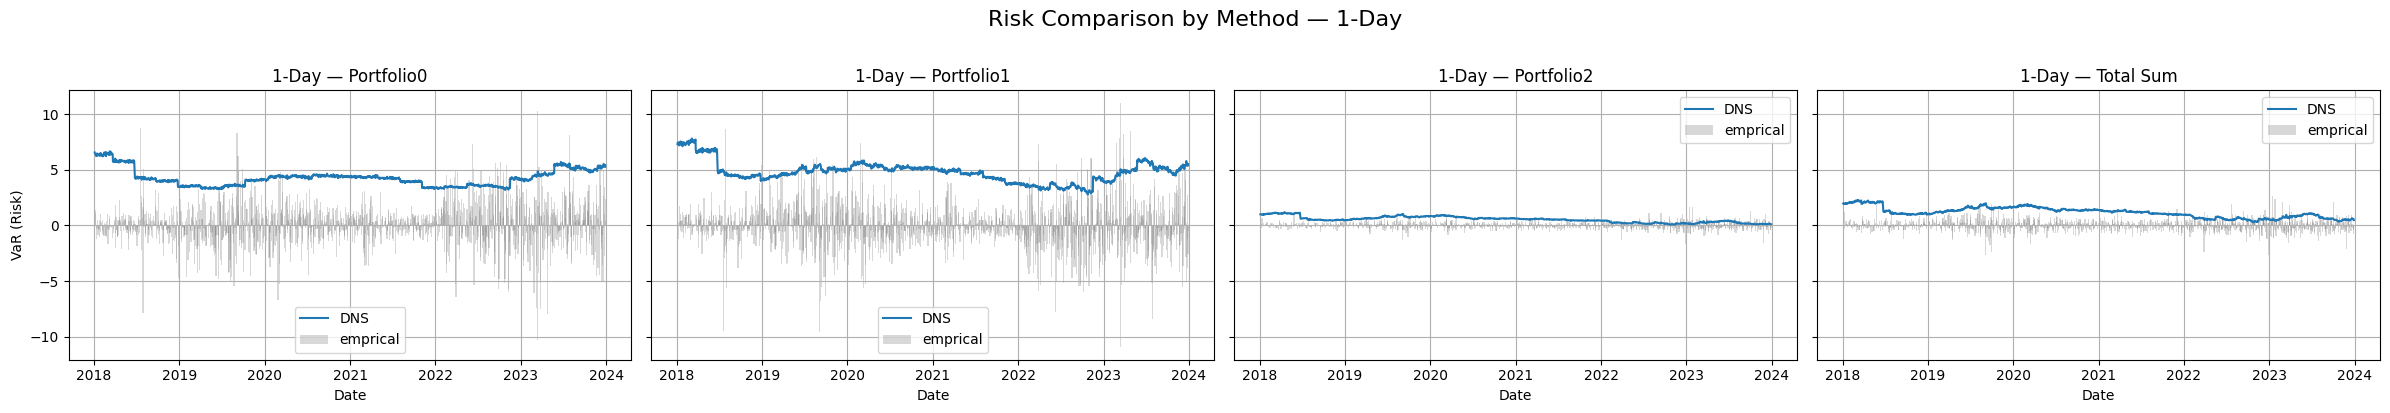

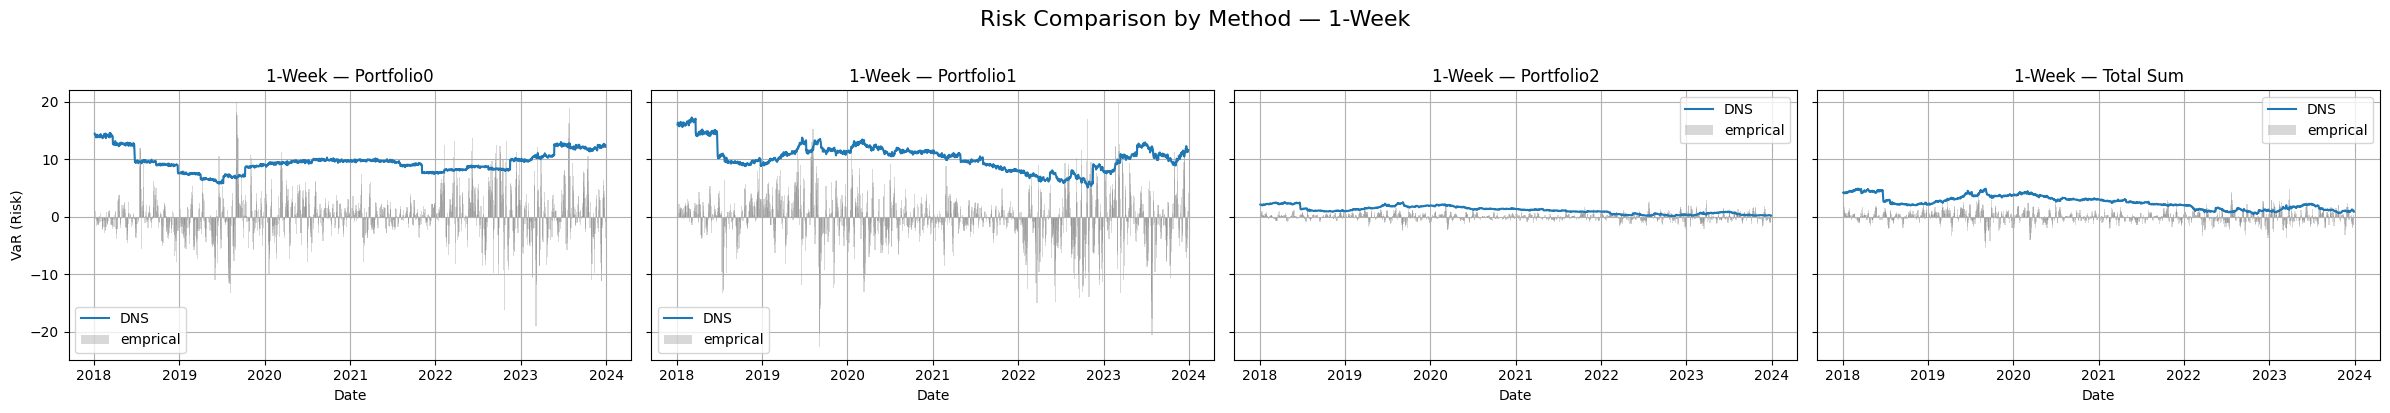

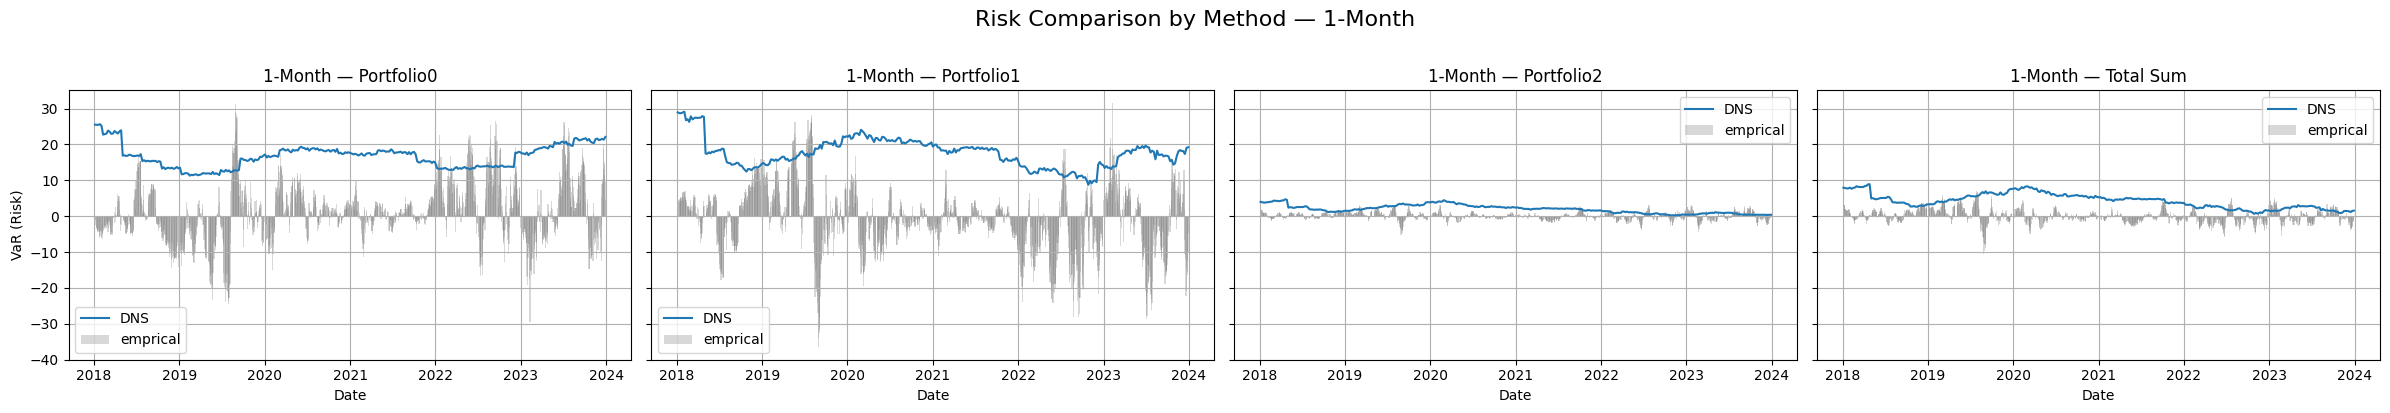

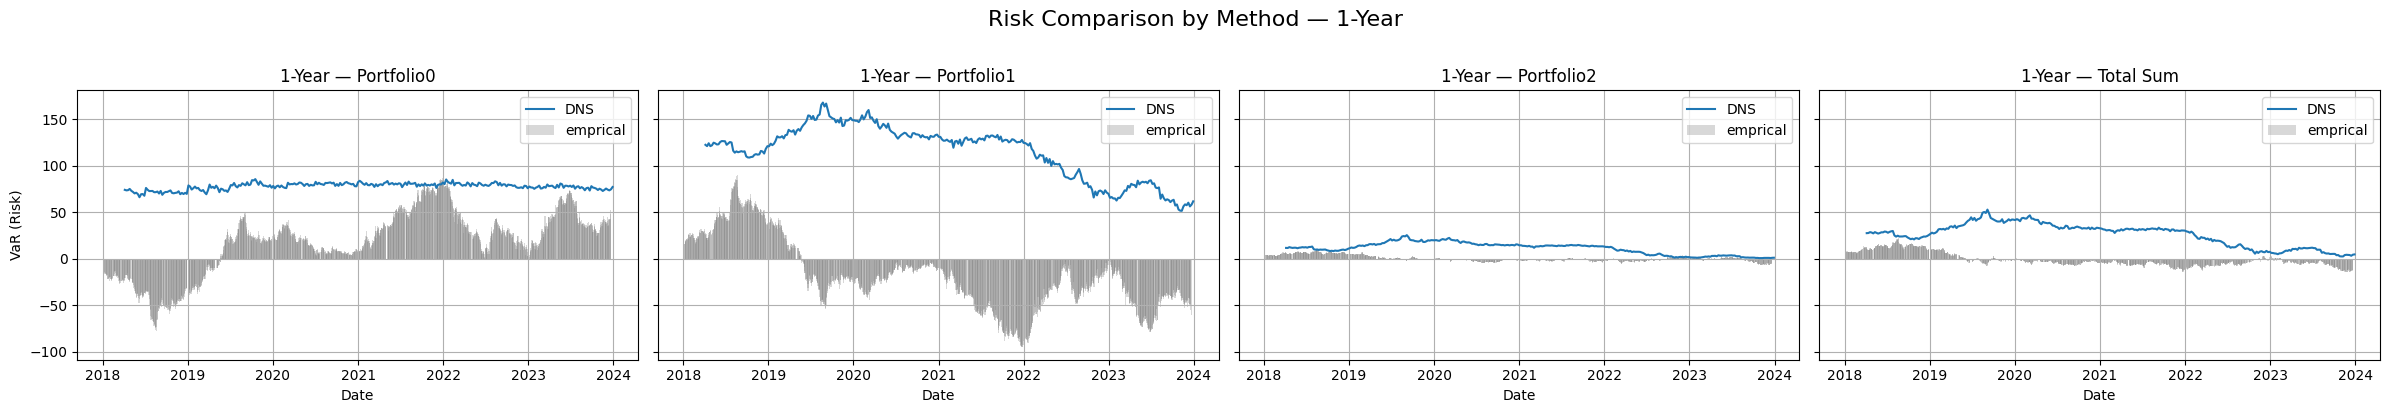

In [ ]:
start_date = pd.to_datetime("2018-01-01")
end_date   = pd.to_datetime("2023-12-31")

emp_risk_df = pd.read_csv("Empirical_risk_v3.1.csv", encoding="utf-8")
emp_risk_df["Base_Date"] = pd.to_datetime(emp_risk_df["Base_Date"])
emp_risk_df = emp_risk_df.rename(columns={
    "Base_Date":"Date",
    "Portfolio_0_risk": "Portfolio0",
    "Portfolio_1_risk": "Portfolio1",
    "Portfolio_2_risk": "Portfolio2",
    "Portfolio_3_risk": "PortfolioSum",
})
emp_risk_df["Label"] = "emprical"

# — DNS (1-Week & 1-Month)
from ast import literal_eval

def load_dns(path, horizon_label,model_label):
    df = pd.read_csv(path)
    df["Date"] = pd.to_datetime(df["Test_Date"])
    df["Risk_Charges"] = df["Risk_Charges"].apply(literal_eval)
    risk = pd.DataFrame(df["Risk_Charges"].tolist(),
                        columns=["Portfolio0","Portfolio1","Portfolio2","PortfolioSum"])
    df = pd.concat([df, risk], axis=1)
    df = df.drop(columns=["Test_Date","Risk_Charges"])
    df["Horizon"] = horizon_label
    df["Label"]   = model_label
    return df[["Date","Portfolio0","Portfolio1","Portfolio2","PortfolioSum","Horizon","Label"]]

dns_d = load_dns("DNS40_1-day_risk_backtest_v3.1.csv",  "1-Day", "DNS")
dns_w = load_dns("DNS40_1-week_risk_backtest_v3.1.csv",  "1-Week","DNS")
dns_m = load_dns("DNS40_1-month_risk_backtest_v3.1.csv","1-Month","DNS")
dns_y = load_dns("DNS40_1-year_risk_backtest_v3.1.csv","1-Year","DNS")
#dns_yregu = load_dns("DNS30regu_1-year_risk_backtest_v3.1.csv","1-Year","DNS_regu")

all_df = pd.concat([emp_risk_df, 
                    dns_d, dns_w, dns_m, 
                    dns_y, 
                    #dns_yregu
                    ],
                   ignore_index=True)

mask = (all_df["Date"] >= start_date) & (all_df["Date"] <= end_date)
all_df = all_df.loc[mask].sort_values("Date")

horizon_order = ["1-Day", "1-Week", "1-Month", "1-Year"]

ports = ["Portfolio0", "Portfolio1", "Portfolio2","PortfolioSum"]

for horizon in horizon_order:
    df_h = all_df[all_df["Horizon"] == horizon]
    if df_h.empty:
        continue

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,4), sharey=True)
    for i, port in enumerate(ports):
        ax = axes[i]
        for label, grp in df_h.groupby("Label"):
            if label == "emprical":
                ax.bar(grp["Date"], grp[port],
                       width=5,
                       alpha=0.3,         
                       color="gray",      
                       label=label)
            else:
                ax.plot(grp["Date"], grp[port],
                        label=label)
        title = port if port!="PortfolioSum" else "Total Sum"
        ax.set_title(f"{horizon} — {title}")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("VaR (Risk)")
        ax.legend()
        ax.grid(True)

    fig.suptitle(f"Risk Comparison by Method — {horizon}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


## (Ref) one point comparison

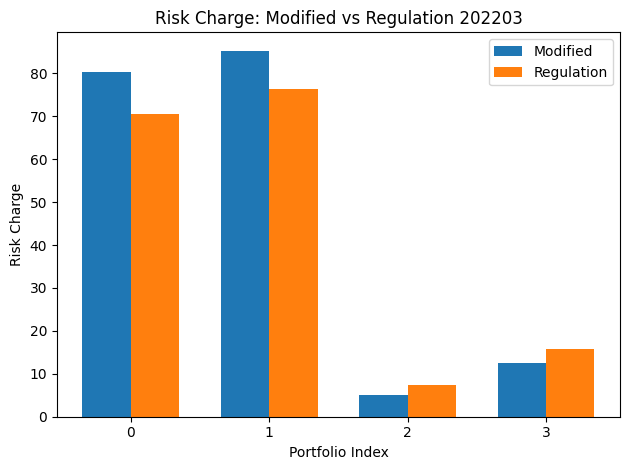

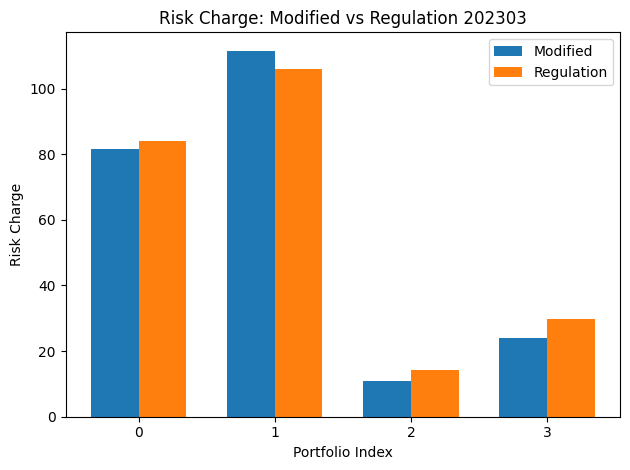

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def analyze_yield_curve(
    file_path,
    portfolio_assets,
    portfolio_liabilities,
    maturities_limit=50,
    n_sims=20000,
    seed=513
):
    df = pd.read_csv(file_path)
    df = df[df["Maturity"] <= maturities_limit].sort_values("Maturity")
    maturities = df["Maturity"].values
    
    scenarios = {
        "Base": "Base Yield",
        "MR": "Mean Reversion",
        "LU": "Level Up",
        "LD": "Level Down",
        "TU": "Twist Up-to-Down",
        "TD": "Twist Down-to-Up"
    }
    curves = {k: df[col].values for k, col in scenarios.items()}
    
    dfs = {k: 1.0 / ((1.0 + curves[k]) ** maturities) for k in curves}
    
    n_portfolios = portfolio_assets.shape[0]
    base_pv = np.array([
        np.sum((portfolio_assets[i] - portfolio_liabilities[i]) * dfs["Base"])
        for i in range(n_portfolios)
    ])

    scenario_pv = {
        k: np.array([
            np.sum((portfolio_assets[i] - portfolio_liabilities[i]) * dfs[k])
            for i in range(n_portfolios)
        ]) for k in ["MR", "LU", "LD", "TU", "TD"]
    }

    diffs = {k: scenario_pv[k] - base_pv for k in scenario_pv}
    
    # Monte Carlo simulation
    rng = np.random.default_rng(seed)
    z_995 = norm.ppf(0.995)
    risk_charge = np.zeros(n_portfolios)
    
    for i in range(n_portfolios):
        X = rng.standard_normal(n_sims)
        Y = rng.standard_normal(n_sims)
        LT = (1.0 / z_995) * (
            diffs["LU"][i] * np.maximum(X, 0) -
            diffs["LD"][i] * np.minimum(X, 0) +
            diffs["TU"][i] * np.maximum(Y, 0) -
            diffs["TD"][i] * np.minimum(Y, 0)
        )
        VaR_995 = np.quantile(LT, 0.995)
        risk_charge[i] = max(0.0, diffs["MR"][i] + VaR_995)
    
    return base_pv, risk_charge

def compare_yield_curves(
    file1,
    file2,
    portfolio_assets,
    portfolio_liabilities,
    title,
    maturities_limit=50,
    n_sims=20000,
    seed=513
):
    _, rc1 = analyze_yield_curve(
        file1, portfolio_assets, portfolio_liabilities,
        maturities_limit, n_sims, seed
    )
    _, rc2 = analyze_yield_curve(
        file2, portfolio_assets, portfolio_liabilities,
        maturities_limit, n_sims, seed
    )
    
    n = rc1.shape[0]
    indices = np.arange(n)
    width = 0.35
    
    plt.figure()
    plt.bar(indices - width/2, rc1, width, label="Modified")
    plt.bar(indices + width/2, rc2, width, label="Regulation")
    plt.xlabel("Portfolio Index")
    plt.ylabel("Risk Charge")
    plt.title(title)
    plt.legend()
    plt.xticks(indices)
    plt.tight_layout()
    plt.show()

compare_yield_curves(
     "DNS40_yield_curves_for_ICSrisk_202303.csv",
     "DNS30_yield_curves_for_ICSrisk_202303_regulation.csv",
     portfolio_assets, portfolio_liabilities,"Risk Charge: Modified vs Regulation 202203"
)
compare_yield_curves(
     "DNS40_yield_curves_for_ICSrisk_202203.csv",
     "DNS30_yield_curves_for_ICSrisk_202203_regulation.csv",
     portfolio_assets, portfolio_liabilities,"Risk Charge: Modified vs Regulation 202303"
)
